In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import requests

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)  # This shows full string content

# Defina o ano-base aqui (será utilizado para o início da coleta e para rebase do PIB real)
ANO_BASE = 2000

In [2]:
# Função para obter os dados mensais do IPCA do Bacen
def obter_deflator_pib(start_date):
    url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.1211/dados?formato=json"
    response = requests.get(url)
    # Verifica se o status da resposta é 200 (OK)
    if response.status_code != 200:
        print(f"Erro ao acessar API (status {response.status_code}).")
        return None  # ou trate de outra forma
    try:
        data = response.json()
    except ValueError as e:
        print("Erro ao decodificar JSON:", e)
        return None
    if not data:
        print("Resposta vazia da API.")
        return None

    df_deflator = pd.DataFrame(data)
    df_deflator['data'] = pd.to_datetime(df_deflator['data'], format='%d/%m/%Y')
    df_deflator['valor'] = df_deflator['valor'].astype(float)
    df_deflator = df_deflator.sort_values('data')
    df_deflator.columns = ['data', 'deflator_pib']
    df_deflator['year'] = df_deflator['data'].dt.year
    df_deflator = df_deflator[df_deflator['data'] >= start_date]
    print("Primeiros 5 registros do Deflator do PIB:")
    print(df_deflator.head())
    print("-" * 50)
    return df_deflator[['year', 'deflator_pib']]

# Função para obter e agregar os dados mensais do PIB nominal do Bacen para dados anuais
def obter_dados_pib_nominal(start_date):
    # Série 4380 para PIB nominal (em milhões de R$)
    url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.4380/dados?formato=json"
    response = requests.get(url)
    data = response.json()
    df_pib = pd.DataFrame(data)
    df_pib['data'] = pd.to_datetime(df_pib['data'], format='%d/%m/%Y')
    df_pib['valor'] = df_pib['valor'].astype(float)
    df_pib = df_pib.sort_values('data')
    df_pib.columns = ['data', 'pib_nominal']
    df_pib = df_pib[df_pib['data'] >= start_date]
    df_pib['year'] = df_pib['data'].dt.year
    df_pib_anual = df_pib.groupby('year', as_index=False)['pib_nominal'].sum()
    print("Primeiros 5 registros do PIB nominal (dados anuais):")
    print(df_pib_anual.head())
    print("-" * 50)
    return df_pib_anual

def obter_cambio_anual(start_date):
    """
    Obtém a taxa de câmbio (dólar comercial) mensal a partir da API do Bacen
    e agrega para obter a média anual.
    """
    # Usando a série 10813 para a cotação média do dólar comercial
    url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.10813/dados?formato=json"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Erro ao acessar API do câmbio (status {response.status_code}).")
        return None
    try:
        data = response.json()
    except ValueError as e:
        print("Erro ao decodificar JSON do câmbio:", e)
        return None
    if not data:
        print("Resposta vazia da API do câmbio.")
        return None

    df_cambio = pd.DataFrame(data)
    df_cambio['data'] = pd.to_datetime(df_cambio['data'], format='%d/%m/%Y')
    df_cambio['valor'] = df_cambio['valor'].astype(float)
    df_cambio = df_cambio.sort_values('data')
    df_cambio.columns = ['data', 'cambio_nominal']
    df_cambio = df_cambio[df_cambio['data'] >= start_date]
    df_cambio['year'] = df_cambio['data'].dt.year
    # Agregação: média anual da taxa de câmbio
    df_cambio_anual = df_cambio.groupby('year', as_index=False)['cambio_nominal'].mean()
    print("Primeiros 5 registros da taxa de câmbio anual:")
    print(df_cambio_anual.head())
    print("-" * 50)
    return df_cambio_anual

def obter_populacao(start_year):
    # 1. Obter a tabela dos censos (ou estimativas oficiais) via API do IBGE (código 1209)
    url_censo = "https://servicodados.ibge.gov.br/api/v3/agregados/1209/variaveis/606?localidades=N1"
    response_censo = requests.get(url_censo)
    data_censo = response_censo.json()
    serie = data_censo[0]['resultados'][0]['series'][0]['serie']
    df_censo = pd.DataFrame(list(serie.items()), columns=['year', 'populacao'])
    df_censo['year'] = df_censo['year'].astype(int)
    df_censo['populacao'] = df_censo['populacao'].astype(float)
    df_censo = df_censo[df_censo['year'] >= start_year]
    
    # 2. Ordenar os dados pelo ano
    df_censo = df_censo.sort_values('year')
    
    # 3. Criar uma série contínua de anos que vai do primeiro ano disponível até 10 anos após o último ano com dados
    last_year = df_censo['year'].max()
    anos_completos = pd.DataFrame({'year': range(df_censo['year'].min(), last_year + 11)})
    df_pop = pd.merge(anos_completos, df_censo, on='year', how='left')
    
    # 4. Interpolar (e extrapolar) os valores faltantes utilizando interpolação linear
    df_pop['populacao'] = df_pop['populacao'].interpolate(method='linear', limit_direction='both')
    df_pop = df_pop.sort_values('year')
    
    print("Primeiros 5 registros da População (dados do censo, interpolados e extrapolados):")
    print(df_pop.head())
    print("-" * 50)
    return df_pop


In [3]:
# Data de início para a coleta dos dados: utiliza o ANO_BASE definido acima
start_date = pd.to_datetime(f"{ANO_BASE}-01-01")
# Obter os dados da população (para o mesmo período)
df_pop = obter_populacao(ANO_BASE)
# Obter os dados do Bacen
df_deflator = obter_deflator_pib(start_date)
df_pib = obter_dados_pib_nominal(start_date)
df_cambio_anual = obter_cambio_anual(start_date)


Primeiros 5 registros da População (dados do censo, interpolados e extrapolados):
   year    populacao
0  2000  169799170.0
1  2001  171894832.9
2  2002  173990495.8
3  2003  176086158.7
4  2004  178181821.6
--------------------------------------------------
Primeiros 5 registros do Deflator do PIB:
         data  deflator_pib  year
36 2000-01-01          5.61  2000
37 2001-01-01          8.23  2001
38 2002-01-01          9.80  2002
39 2003-01-01         14.09  2003
40 2004-01-01          7.75  2004
--------------------------------------------------
Primeiros 5 registros do PIB nominal (dados anuais):
   year  pib_nominal
0  2000    1199092.0
1  2001    1315755.5
2  2002    1488787.1
3  2003    1717950.4
4  2004    1957751.3
--------------------------------------------------
Primeiros 5 registros da taxa de câmbio anual:
   year  cambio_nominal
0  2000        1.828699
1  2001        2.351416
2  2002        2.930136
3  2003        3.070726
4  2004        2.924927
-----------------------

In [4]:
# ================= Coleta e Agregação dos Dados ==================

# A) Unir os dados anuais (PIB e deflator) pelo ano
df_merged = pd.merge(df_pib, df_deflator, on='year')
df_merged = df_merged.sort_values('year')
# Calcular o fator acumulado de inflação (deflator)
# Produto cumulativo dos fatores (1 + ipca_anual/100) a partir do ANO_BASE
df_merged['fator_acumulado'] = (1 + df_merged['deflator_pib'] / 100).cumprod()
# Calcular o PIB real (em preços do ano-base): dividindo o PIB nominal pelo deflator
df_merged['pib_real'] = df_merged['pib_nominal'] / df_merged['fator_acumulado']
# Normalizar o PIB real para que o ano-base seja igual a 100
pib_real_base = df_merged.loc[df_merged['year'] == ANO_BASE, 'pib_real'].values[0]
df_merged['indice_pib_real'] = (df_merged['pib_real'] / pib_real_base) * 100
df_merged['crescimento_pib_real'] = df_merged['indice_pib_real'].pct_change() * 100


# B) Unir a população com os dados já agregados
df_merged = pd.merge(df_merged, df_pop, on='year')
df_merged = df_merged.sort_values('year')
# Calcular o PIB real per capita (convertendo o PIB real de milhões para R$)
df_merged['pib_real_percapita'] = (df_merged['pib_real'] * 1e6) / df_merged['populacao']
# Normalizar o PIB real per capita para que o ano-base seja igual a 100
pib_real_pc_base = df_merged.loc[df_merged['year'] == ANO_BASE, 'pib_real_percapita'].values[0]
df_merged['indice_pib_real_percapita'] = (df_merged['pib_real_percapita'] / pib_real_pc_base) * 100
df_merged['crescimento_pib_real_percapita'] = df_merged['indice_pib_real_percapita'].pct_change() * 100


# C) Obter os dados da taxa de câmbio anual
# Mesclar a taxa de câmbio com os demais dados
df_merged = pd.merge(df_merged, df_cambio_anual, on='year', how='left')
# Calcular a variação percentual da taxa de câmbio
df_merged['variacao_cambio'] = df_merged['cambio_nominal'].pct_change() * 100
# Converter PIB real e PIB real per capita para "PPP" (PPC)
# Aqui, para ilustração, dividimos pelo câmbio nominal.
df_merged['pib_real_ppp'] = df_merged['pib_real'] / df_merged['cambio_nominal']
df_merged['pib_real_percapita_ppp'] = df_merged['pib_real_percapita'] / df_merged['cambio_nominal']
# Para facilitar a comparação, indexamos os valores em PPP usando o ano-base = 100
pib_real_ppp_base = df_merged.loc[df_merged['year'] == ANO_BASE, 'pib_real_ppp'].values[0]
df_merged['indice_pib_real_ppp'] = (df_merged['pib_real_ppp'] / pib_real_ppp_base) * 100
df_merged['crescimento_pib_real_ppp'] = df_merged['indice_pib_real_ppp'].pct_change() * 100
pib_real_percapita_ppp_base = df_merged.loc[df_merged['year'] == ANO_BASE, 'pib_real_percapita_ppp'].values[0]
df_merged['indice_pib_real_percapita_ppp'] = (df_merged['pib_real_percapita_ppp'] / pib_real_percapita_ppp_base) * 100
df_merged['crescimento_pib_real_percapita_ppp'] = df_merged['indice_pib_real_percapita_ppp'].pct_change() * 100

print("Dados completos (com população e PIB per capita):")
print(df_merged.head())
print("-" * 50)

Dados completos (com população e PIB per capita):
   year  pib_nominal  deflator_pib  fator_acumulado      pib_real  \
0  2000    1199092.0          5.61         1.056100  1.135396e+06   
1  2001    1315755.5          8.23         1.143017  1.151125e+06   
2  2002    1488787.1          9.80         1.255033  1.186254e+06   
3  2003    1717950.4         14.09         1.431867  1.199798e+06   
4  2004    1957751.3          7.75         1.542836  1.268930e+06   

   indice_pib_real  crescimento_pib_real    populacao  pib_real_percapita  \
0       100.000000                   NaN  169799170.0         6686.700938   
1       101.385309              1.385309  171894832.9         6696.681914   
2       104.479261              3.051677  173990495.8         6817.922029   
3       105.672148              1.141745  176086158.7         6813.696423   
4       111.760969              5.761992  178181821.6         7121.545057   

   indice_pib_real_percapita  crescimento_pib_real_percapita  cambio_nom

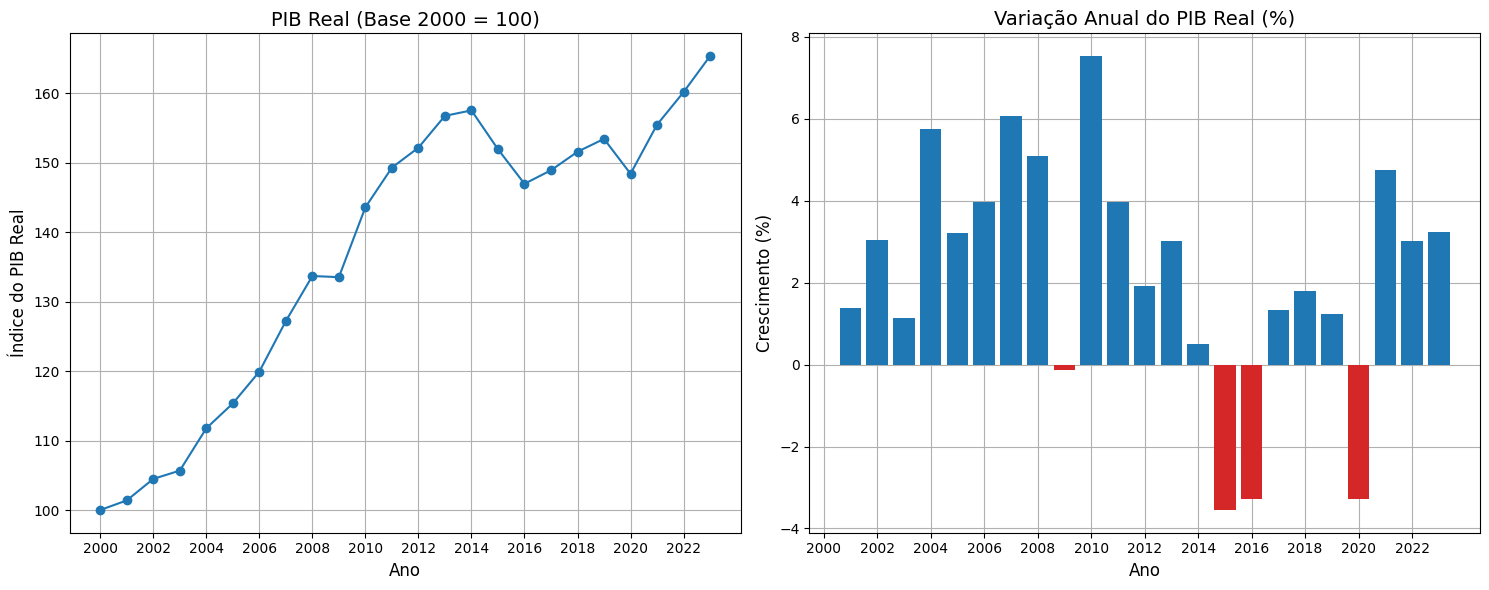

In [5]:
def setup_ax(ax, title, xlabel='Ano', ylabel=''):
    ax.set_title(title, fontsize=14)  # título um pouco maior
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_ylabel(ylabel)

# ----- Gráfico 1: Dados Totais (Primeira Linha) -----
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # figura com 1 linha e 2 colunas
for ax in axs:
    ax.grid(True, zorder=0)

# Subplot 1: Evolução do PIB real indexado (base ANO_BASE = 100)
axs[0].plot(df_merged['year'], df_merged['indice_pib_real'], 'o-', zorder=2)
setup_ax(axs[0], f'PIB Real (Base {ANO_BASE} = 100)', ylabel='Índice do PIB Real')

# Subplot 2: Crescimento anual do PIB real em barras
cores = ['tab:red' if x < 0 else 'tab:blue' for x in df_merged['crescimento_pib_real']]
axs[1].bar(df_merged['year'], df_merged['crescimento_pib_real'], color=cores, zorder=2)
setup_ax(axs[1], 'Variação Anual do PIB Real (%)', ylabel='Crescimento (%)')

for ax in axs:
    ax.set_xticks(df_merged['year'][::2])
plt.tight_layout()
plt.show()

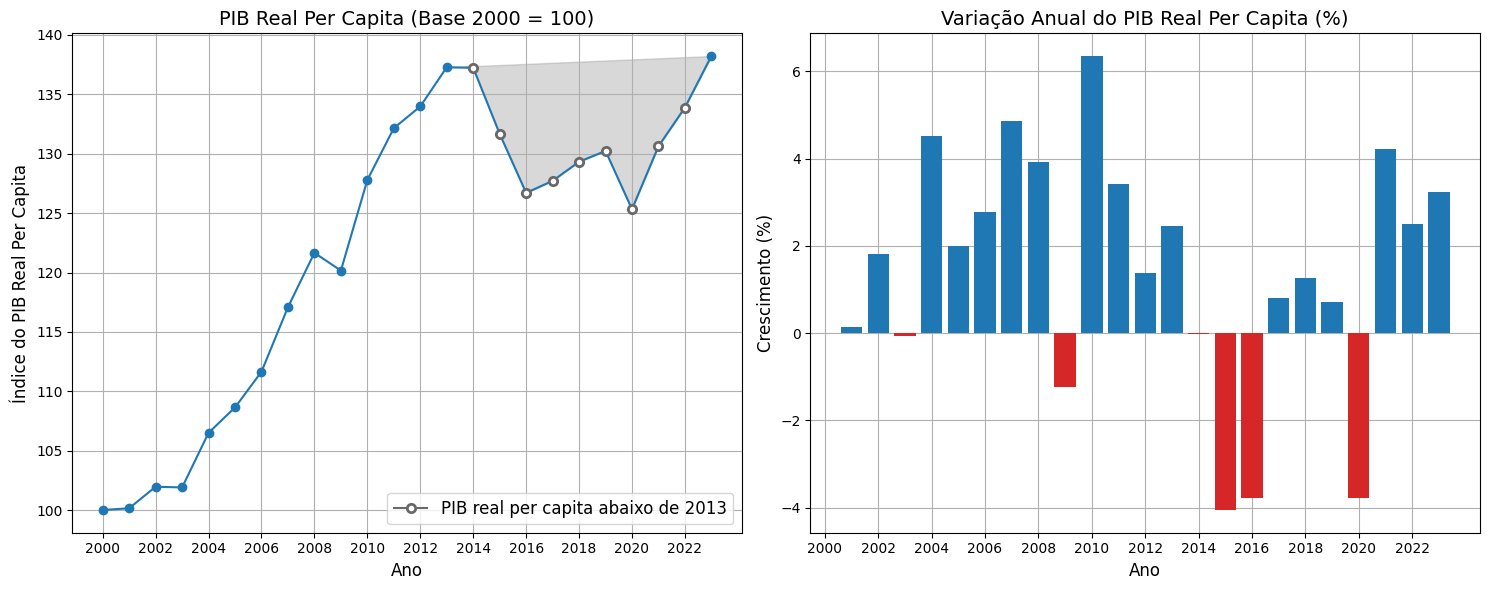

In [6]:
# ----- Gráfico 2: Dados Per Capita (Segunda Linha) -----
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # nova figura com 1 linha e 2 colunas
for ax in axs:
    ax.grid(True, zorder=0)

# ----- Subplot 1: Evolução do PIB Real Per Capita -----
ax1 = axs[0]
ax1.plot(df_merged['year'], df_merged['indice_pib_real_percapita'], 'o-', zorder=2)
setup_ax(ax1, f'PIB Real Per Capita (Base {ANO_BASE} = 100)', ylabel='Índice do PIB Real Per Capita')

# Mask entre 2013 and 2023
mask = (df_merged['year'] >= 2013) & (df_merged['year'] <= 2023)
x_fill = df_merged['year'][mask]
y_fill = df_merged['indice_pib_real_percapita'][mask]
# Preenchendo entre os anos
y_base = y_fill.iloc[0] + (y_fill.iloc[-1] - y_fill.iloc[0]) / (x_fill.iloc[-1] - x_fill.iloc[0]) * (x_fill - x_fill.iloc[0])
ax1.fill_between(x_fill, y_fill, y_base, color='gray', alpha=0.3, zorder=1)

# Identificando o período abaixo do recorde anual em 2013
y_2013 = df_merged.loc[df_merged['year'] == 2013, 'indice_pib_real_percapita'].iloc[0]
mask_low = (df_merged['year'] > 2013) & (df_merged['year'] <= 2023) & (df_merged['indice_pib_real_percapita'] < y_2013)
x_low = df_merged.loc[mask_low, 'year']
y_low = df_merged.loc[mask_low, 'indice_pib_real_percapita']

# Legenda
ax1.scatter(x_low, y_low, facecolors='white', edgecolors='dimgray', linewidth=2, zorder=3)
legend_marker = mlines.Line2D([], [], marker='o', c='dimgray', mfc='white', ms=6, mew=2, label='PIB real per capita abaixo de 2013')
ax1.legend(handles=[legend_marker], loc='lower right', fontsize=12)


# Subplot 2: Crescimento anual do PIB real per capita em barras
cores_pc = ['tab:red' if x < 0 else 'tab:blue' for x in df_merged['crescimento_pib_real_percapita']]
axs[1].bar(df_merged['year'], df_merged['crescimento_pib_real_percapita'], color=cores_pc, zorder=2)
setup_ax(axs[1], 'Variação Anual do PIB Real Per Capita (%)', ylabel='Crescimento (%)')

for ax in axs:
    ax.set_xticks(df_merged['year'][::2])
plt.tight_layout()
plt.show()

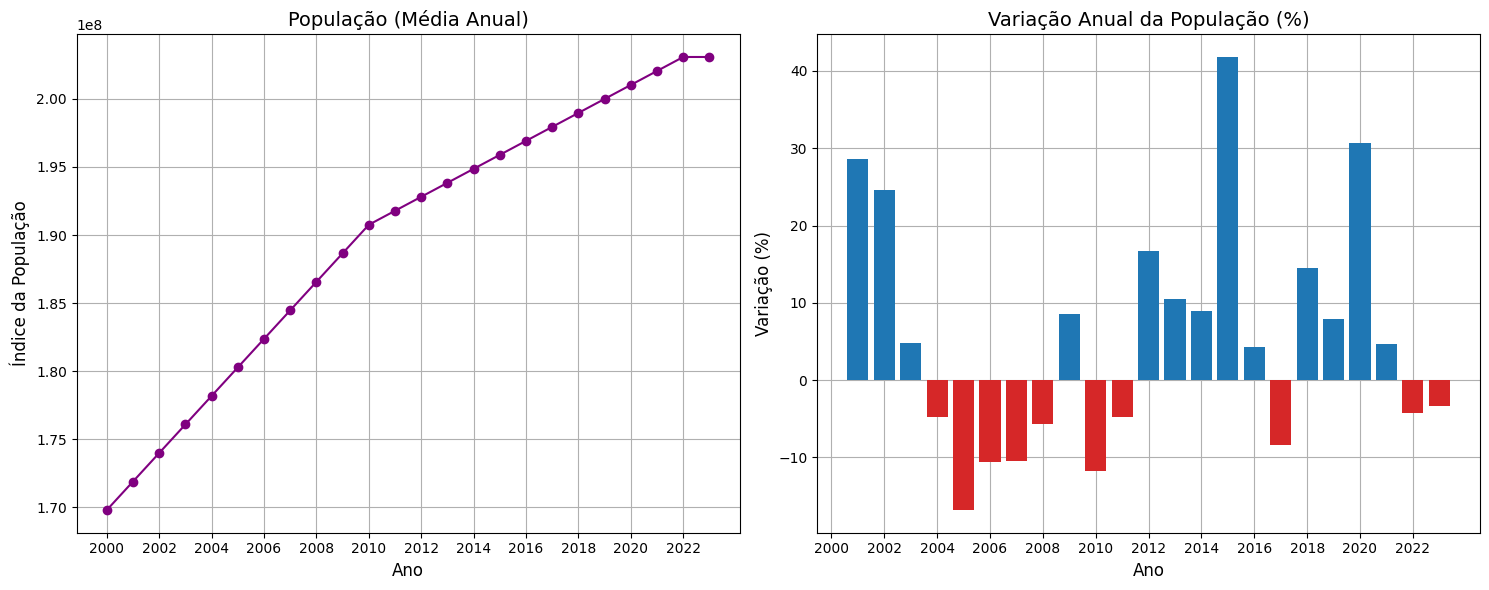

In [7]:
# ================= Gráfico 3: Taxa de Câmbio e sua Variação ==================

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for ax in axs:
    ax.grid(True, zorder=0)

# Subplot 1: Evolução da taxa de câmbio nominal
axs[0].plot(df_merged['year'], df_merged['populacao'], 'o-', color='purple', zorder=2)
setup_ax(axs[0], 'População (Média Anual)', ylabel='Índice da População')
# Subplot 2: Variação percentual da taxa de câmbio
cores_cambio = ['tab:red' if x < 0 else 'tab:blue' for x in df_merged['variacao_cambio']]
axs[1].bar(df_merged['year'], df_merged['variacao_cambio'], color=cores_cambio, zorder=2)
setup_ax(axs[1], 'Variação Anual da População (%)', ylabel='Variação (%)')
for ax in axs:
    ax.set_xticks(df_merged['year'][::2])
plt.tight_layout()
plt.show()

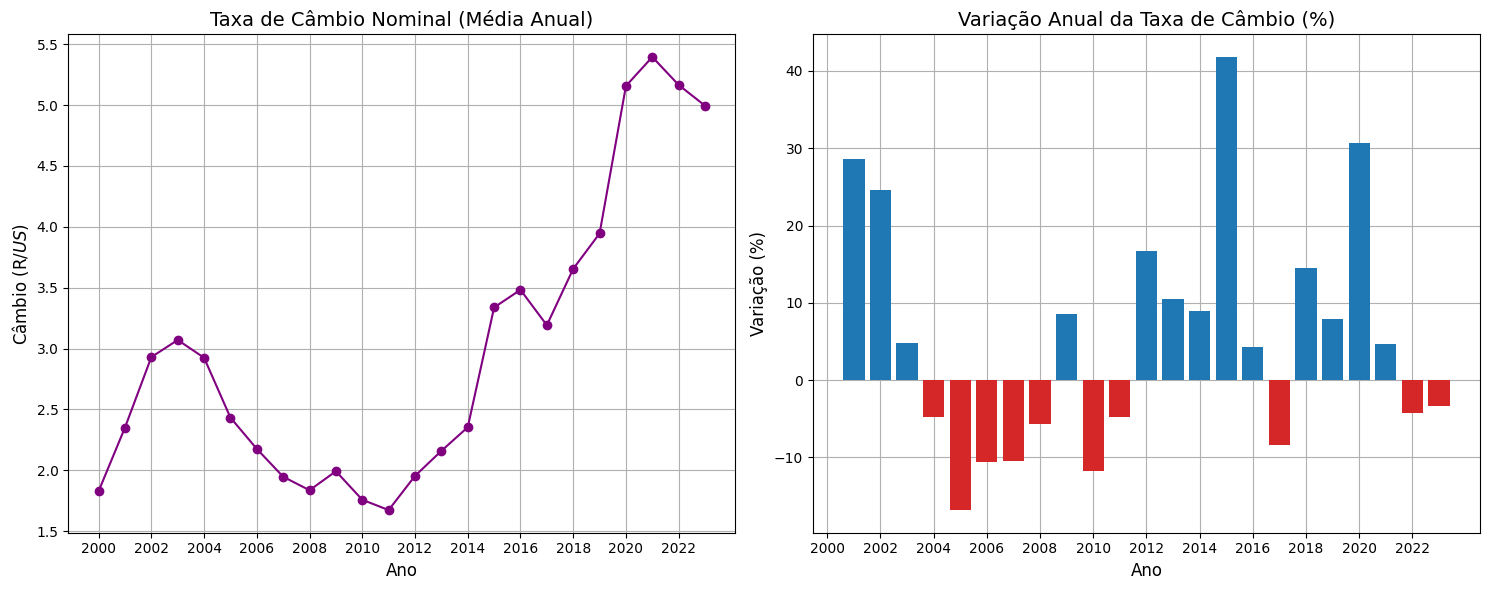

In [8]:
# ================= Gráfico 4: Taxa de Câmbio e sua Variação ==================

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for ax in axs:
    ax.grid(True, zorder=0)

# Subplot 1: Evolução da taxa de câmbio nominal
axs[0].plot(df_merged['year'], df_merged['cambio_nominal'], 'o-', color='purple', zorder=2)
setup_ax(axs[0], 'Taxa de Câmbio Nominal (Média Anual)', ylabel='Câmbio (R$/US$)')
# Subplot 2: Variação percentual da taxa de câmbio
cores_cambio = ['tab:red' if x < 0 else 'tab:blue' for x in df_merged['variacao_cambio']]
axs[1].bar(df_merged['year'], df_merged['variacao_cambio'], color=cores_cambio, zorder=2)
setup_ax(axs[1], 'Variação Anual da Taxa de Câmbio (%)', ylabel='Variação (%)')
for ax in axs:
    ax.set_xticks(df_merged['year'][::2])
plt.tight_layout()
plt.show()


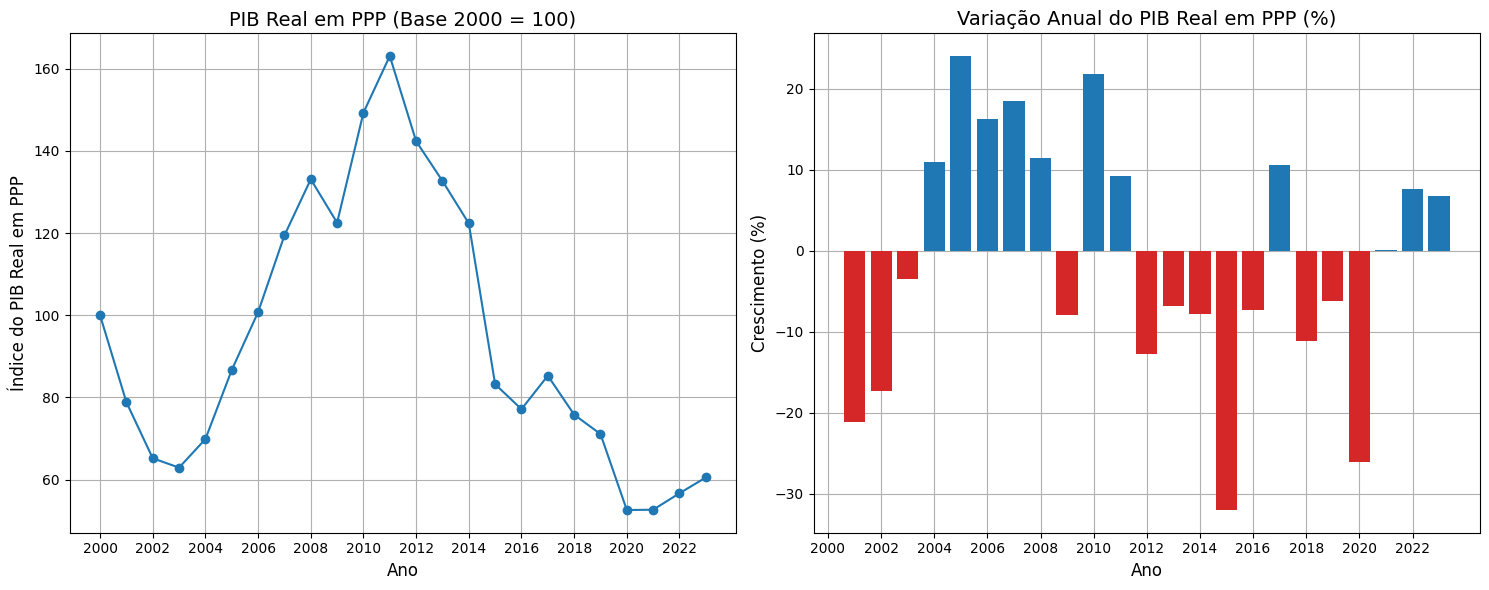

In [9]:
# ================= Gráfico 5: PIB Real em "PPP" (PPC) ==================

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for ax in axs:
    ax.grid(True, zorder=0)

# Subplot 1: Evolução do PIB real em PPP indexado (base ANO_BASE = 100)
axs[0].plot(df_merged['year'], df_merged['indice_pib_real_ppp'], 'o-', zorder=2)
setup_ax(axs[0], f'PIB Real em PPP (Base {ANO_BASE} = 100)', ylabel='Índice do PIB Real em PPP')
# Subplot 2: Crescimento anual do PIB real em PPP
cores_ppp = ['tab:red' if x < 0 else 'tab:blue' for x in df_merged['crescimento_pib_real_ppp']]
axs[1].bar(df_merged['year'], df_merged['crescimento_pib_real_ppp'], color=cores_ppp, zorder=2)
setup_ax(axs[1], 'Variação Anual do PIB Real em PPP (%)', ylabel='Crescimento (%)')
for ax in axs:
    ax.set_xticks(df_merged['year'][::2])
plt.tight_layout()
plt.show()


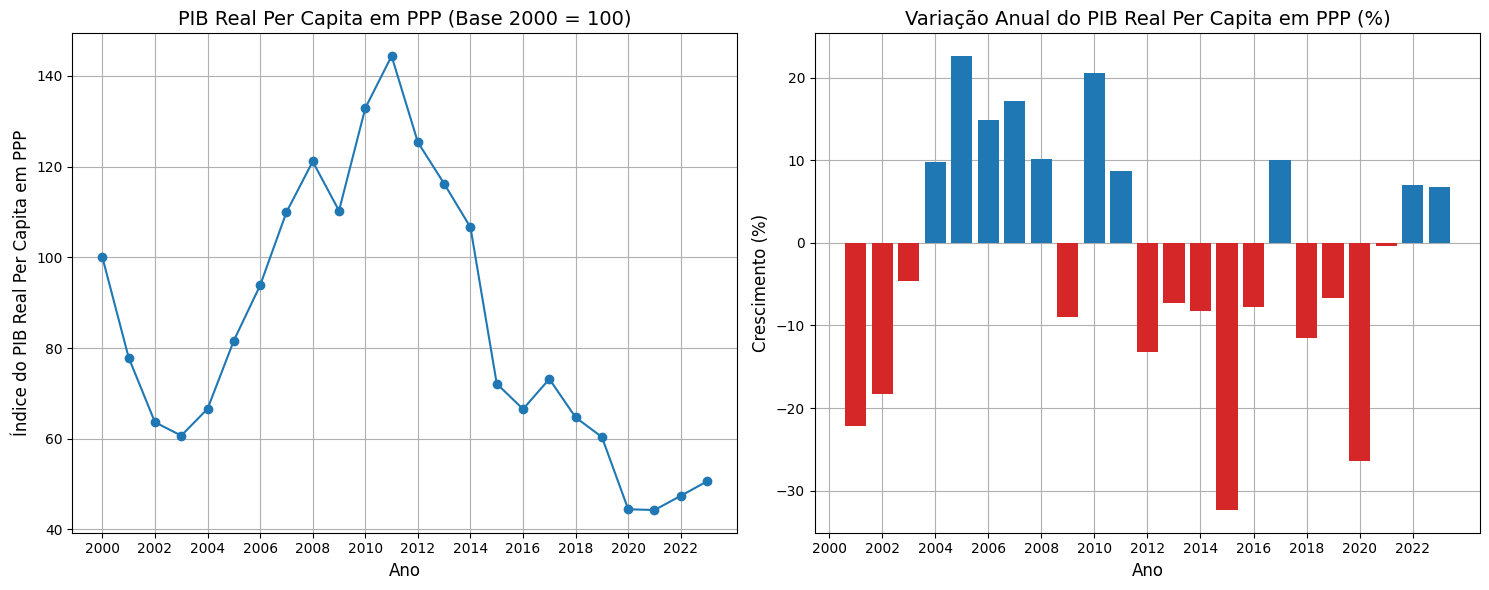

In [10]:
# ================= Gráfico 6: PIB Real Per Capita em "PPP" (PPC) ==================

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for ax in axs:
    ax.grid(True, zorder=0)
    
# Subplot 1: Evolução do PIB real per capita em PPP indexado (base ANO_BASE = 100)
axs[0].plot(df_merged['year'], df_merged['indice_pib_real_percapita_ppp'], 'o-', zorder=2)
setup_ax(axs[0], f'PIB Real Per Capita em PPP (Base {ANO_BASE} = 100)', ylabel='Índice do PIB Real Per Capita em PPP')
# Subplot 2: Crescimento anual do PIB real per capita em PPP
cores_pc_ppp = ['tab:red' if x < 0 else 'tab:blue' for x in df_merged['crescimento_pib_real_percapita_ppp']]
axs[1].bar(df_merged['year'], df_merged['crescimento_pib_real_percapita_ppp'], color=cores_pc_ppp, zorder=2)
setup_ax(axs[1], 'Variação Anual do PIB Real Per Capita em PPP (%)', ylabel='Crescimento (%)')
for ax in axs:
    ax.set_xticks(df_merged['year'][::2])
plt.tight_layout()
plt.show()
